# Direction selectivity analysis

In [24]:
import pynwb, os
import numpy as np
from datavyz import graph_env_manuscript as ge
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 1000

import sys
# sys.path.append('C:\\Users\\yann.zerlaut\\work\\physion')
sys.path.append('/home/yann/work/physion')
from physion.dataviz import plots
from physion.analysis.read_NWB import read as read_NWB
from physion.analysis.trial_averaging import build_episodes

class Data:
    
    def __init__(self, filename, 
                 protocol_id=0,
                 quantity='CaImaging', 
                 subquantity='Fluorescence', 
                 roiIndex = 0,
                 verbose=False):
        """ opens data file and build the episodes corresponding to a specific protocol """
        read_NWB(self, filename, verbose=False)
        if verbose:
            print('Building episodes for "%s"' % self.protocols[protocol_id])
        self.EPISODES = build_episodes(self, protocol_id=protocol_id)
        
        self.find_varied_parameters()
        if verbose:
            print('parameters varied:', self.varied_parameters)
        
    def find_varied_parameters(self):
        """ find the parameter(s) varied within a specific protocol """
        self.varied_parameters =  {}
        for key in self.nwbfile.stimulus.keys():
            if key not in ['frame_run_type', 'index', 'protocol_id', 'repeat', 'time_duration', 'time_start',
                           'time_start_realigned', 'time_stop', 'time_stop_realigned']:
                unique = np.unique(self.EPISODES[key])
                if len(unique)>1:
                    self.varied_parameters[key] = unique

    def compute_repeated_trials(self, key, index):
        cond = (self.EPISODES[key]==self.varied_parameters[key][index])
        return np.array([])
    
    
filename = os.path.join(os.path.expanduser('~'), 'DATA', 'data.nwb')

data = Data(filename, 1)
print(data.varied_parameters)


Number of episodse over the whole recording: 80/120 (with protocol condition)
[ok] episodes ready !
{'angle': array([  0.,  45.,  90., 135., 180., 225., 270., 315.])}


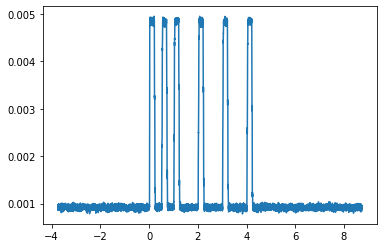

In [25]:
plt.plot(data.EPISODES['t'], np.mean(data.EPISODES['Photodiode-Signal'], axis=0))

In [26]:
data.nwbfile.stimulus['protocol_id'].data[:]==0

array([ True, False, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True, False, False, False,  True,  True,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False,  True, False, False, False,
        True, False,  True, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False,  True,  True,  True,  True, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
        True, False, False, False,  True,  True,  True, False, False,
       False, False, False, False,  True, False,  True, False, False,
        True, False, False, False,  True, False, False, False, False,
        True,  True, False, False,  True, False,  True, False, False,
       False, False,  True])

In [27]:

def selectivity_index(angles, resp):
    imax = np.argmax(resp)
    iop = np.argmin(((angles[imax]+np.pi/2.)%(2*np.pi)-angles)**2)
    return min([1,max([0,(resp[imax]-resp[iop])/(resp[imax]+resp[iop])])])

def make_selectivity_plots(data, roi=0,
                           dt_sampling=0.1,
                           noise_threshold=2.,
                           with_fig=True):
    data.roiIndices = [roi]
    EPISODES = build_episodes(data, quantity='CaImaging', dt_sampling=1e3*dt_sampling, verbose=False)

    angles = np.unique(data.nwbfile.stimulus['angle'].data[:])
    updated_angles = np.linspace(0, 180, len(angles)+1)[:-1] # TEMPORARY
    integral, max_resp = np.zeros(len(angles)), np.zeros(len(angles))
    noise_estimate = np.zeros(len(angles))
    tresp_cond = (EPISODES['t']>0) & (EPISODES['t']<=data.metadata['presentation-duration'])
    SET_OF_ANGLE_COND = build_conditions(data, [angles], ['angle'])
    
    if with_fig:
        fig, ax = ge.figure(figsize=(2.7,1.3), left=0, bottom=0)
    for i, cond in enumerate(SET_OF_ANGLE_COND):
        new_cond = cond[:len(EPISODES['CaImaging'])] # to deal with stoped protocols
        F0 = np.array(EPISODES['CaImaging'])[new_cond,:][:,EPISODES['t']<=0].mean(axis=1)
        dF = np.array((np.array(EPISODES['CaImaging'])[new_cond,:].T-F0)/F0).T
        if with_fig:
            tplot = i*(1+EPISODES['t'][-1]-EPISODES['t'][0])
            ge.plot(EPISODES['t']+tplot, dF.mean(axis=0), sy=dF.std(axis=0), ax=ax, no_set=True)
        integral[i] = np.trapz(dF.mean(axis=0)[tresp_cond], np.arange(len(dF.mean(axis=0)[tresp_cond]))*dt_sampling)
        max_resp[i] = dF.mean(axis=0)[tresp_cond].max()
        noise_estimate[i] = dF.std(axis=0)[EPISODES['t']<=0].mean()
    if with_fig:
        ylim=ax.get_ylim()
        for i, cond in enumerate(SET_OF_ANGLE_COND):
            tplot = i*(1+EPISODES['t'][-1]-EPISODES['t'][0])
            ge.annotate(ax, '%.0f$^o$' % updated_angles[i], (tplot, 1.2), xycoords='data')
            ax.fill_between([tplot+0, tplot+data.metadata['presentation-duration']],
                            ylim[0]*np.ones(2), ylim[1]*np.ones(2), alpha=.1, color=ge.blue, lw=0)
        ge.set_plot(ax, [], ylim=[-.3,1.2])
        ge.draw_bar_scales(ax, Xbar=3, Xbar_label='3s', Ybar=0.5, Ybar_label='50%$\Delta$F/F', loc='top-left')

    if np.sum((max_resp>noise_threshold*noise_estimate)):
        responsive=True
        if with_fig:
            ge.annotate(fig, 'responsive  ', (1.,0.05), ha='right', color='darkgreen', bold=True)
    else:
        responsive=False
        if with_fig:
            ge.annotate(fig, 'non-responsive  ', (1., 0.05), ha='right', color=ge.red)
    angles = np.concatenate([updated_angles/180*np.pi, np.pi+updated_angles/180*np.pi, [2*np.pi]])
    resp = np.concatenate([integral, integral, [integral[0]]])
    if with_fig:
        ax = plt.axes([.94,.1,.1,.6], projection='polar')
        ax.plot(angles, resp, color='k', lw=2)
        ax.set_rticks([])
        ax.set_xticklabels([])
        si = selectivity_index(angles, resp)
        ge.annotate(fig, 'ROI:%i' % (roi+1), (0,.5), va='center')
        ge.annotate(fig, 'SI=%.2f ' % si, (1,.9), va='top', ha='right')
        return fig, si, responsive
    else:
        return None, selectivity_index(angles, resp), responsive
    
def show_response(filename):
    data = Data(filename)
    SI = []
    for i in range(np.sum(data.iscell)):
        fig, si, responsive = make_selectivity_plots(data, roi=i, noise_threshold=2.5, with_fig=True)
        if responsive:
            SI.append(si)
    x = [len(SI), np.sum(data.iscell)-len(SI)]
    fig, ax = ge.pie(x,
                     ext_labels = ['responsive\n %.1f%%, n=%i' % (100*x[0]/np.sum(x), x[0]),
                                   'non-reponsive\n %.1f%%, n=%i' % (100*x[1]/np.sum(x), x[1])],
                     ext_labels_distance=1.2,
                     explodes=0.05*np.ones(len(x)), center_circle=0.2,
                     COLORS = ['darkgreen', ge.red],
                     legend=None)
    if len(SI)>0:
        hist, be = np.histogram(SI, bins=np.linspace(0, max(SI)), density=False)
        fig, ax = ge.plot(be[1:], 100*np.cumsum(hist)/len(SI))
        ge.set_plot(ax, yticks=[0,50,100], ylabel='fraction (%)\n of resp. neurons', xlabel='OSI')
    

In [ ]:
filename = os.path.join('D:\\', 'Fani', '2020_11_19', '11-40-32', '2020_11_19-11-40-32.LIGHTWEIGHT.nwb')
show_response(filename)

In [ ]:
FULL_SI, Ntot, = [], 0
LIST = [\
        os.path.join('2021_01_15', "2021_01_15-11-12-50.['processed_CaImaging', 'VisualStim', 'Locomotion', 'Pupil', 'Whisking', 'Electrophy'].nwb"),\
        os.path.join('2021_01_15', "2021_01_15-12-13-54.['processed_CaImaging', 'VisualStim', 'Locomotion', 'Pupil', 'Whisking', 'Electrophy'].nwb"),\
        os.path.join('2021_01_15', "2021_01_15-15-44-52.['processed_CaImaging', 'VisualStim', 'Locomotion', 'Pupil', 'Whisking', 'Electrophy'].nwb"),\
        os.path.join('2021_01_15', "2021_01_15-16-09-19.['processed_CaImaging', 'VisualStim', 'Locomotion', 'Pupil', 'Whisking', 'Electrophy'].nwb"),\
        os.path.join('2020_11_12', "2020_11_12-17-54-24.FULL.nwb"),\
        ]

for l, fn in enumerate(LIST):
    filename = os.path.join(os.path.expanduser('~'), 'DATA', fn)
    data = Data(filename)
    Ntot += np.sum(data.iscell)
    SI = []
    for i in range(np.sum(data.iscell)):
        fig, si, responsive = make_selectivity_plots(data, roi=i, noise_threshold=2.5, with_fig=True)
        if responsive:
            SI.append(si)
    x = [len(SI), np.sum(data.iscell)-len(SI)]
    fig, ax = ge.pie(x,
                     ext_labels = ['responsive\n %.1f%%, n=%i' % (100*x[0]/np.sum(x), x[0]),
                                   'non-reponsive\n %.1f%%, n=%i' % (100*x[1]/np.sum(x), x[1])],
                     ext_labels_distance=1.2,
                     explodes=0.05*np.ones(len(x)), center_circle=0.2,
                     COLORS = ['darkgreen', ge.red],
                     legend=None)
    FULL_SI = FULL_SI+SI
    if len(SI)>0:
        hist, be = np.histogram(SI, bins=np.linspace(0, max(SI)), density=False)
        fig, ax = ge.plot(be[1:], 100*np.cumsum(hist)/len(SI))
        ge.set_plot(ax, yticks=[0,50,100], ylabel='fraction (%)\n of resp. neurons', xlabel='OSI')

In [ ]:
x = [len(FULL_SI), Ntot-len(FULL_SI)]
fig, ax = ge.pie(x,
                 ext_labels = ['responsive\n %.1f%%, n=%i' % (100*x[0]/Ntot, x[0]),
                               'non-reponsive\n %.1f%%, n=%i' % (100*x[1]/Ntot, x[1])],
                 ext_labels_distance=1.2,
                 explodes=0.05*np.ones(len(x)), center_circle=0.2,
                 COLORS = ['darkgreen', ge.red],
                 legend=None)
hist, be = np.histogram(FULL_SI, bins=np.linspace(0, max(FULL_SI)), density=False)
fig, ax = ge.plot(be[1:], 100*np.cumsum(hist)/len(FULL_SI))
ge.set_plot(ax, yticks=[0,50,100], ylabel='fraction (%)\n of resp. neurons', xlabel='OSI')

In [ ]:
import pynwb, os
filename = os.path.join(os.path.expanduser('~'), 'DATA', '2021_01_15', "2021_01_15-16-09-19.FULL.nwb")
io = pynwb.NWBHDF5IO(filename, 'r')
nwbfile = io.read()

In [ ]:
def scale_and_position(y, value=None, i=0, blank_space=0.1, increase_factor=2.):
    if value is None:
        value=y
    ymin, ymax = y.min(), y.max()
    if ymin<ymax:
        return shift(i, increase_factor=increase_factor, blank_space=blank_space)+\
            increase_factor**i*\
            (value-ymin)/(ymax-ymin)
    else:
        return shift(i)+value

def shift(i, blank_space=0.1, increase_factor=1):
    return blank_space*i+\
        np.sum(np.power(increase_factor, np.arange(i)))

def show_recording(nwbfile, pupil, tlim=[0, 60], Npoints=1e3):
    fig, ax = ge.figure(figsize=(3,3))
    iplot=0

    # running speed
    i1 = plots.convert_time_to_index(tlim[0], nwbfile.acquisition['Running-Speed'])
    i2 = plots.convert_time_to_index(tlim[1], nwbfile.acquisition['Running-Speed'])
    isampling = np.unique(np.linspace(i1, i2, int(Npoints), dtype=int))
    y = scale_and_position(nwbfile.acquisition['Running-Speed'].data[isampling], i=iplot, increase_factor=2.3)
    ax.plot(plots.convert_index_to_time(isampling, nwbfile.acquisition['Running-Speed']), y, color=ge.grey, lw=2)
    ge.annotate(ax, 'Running speed', (tlim[0]+30, y[0]), xycoords='data', color=ge.grey, size='large', va='top')
    iplot+=1
    # pupil diameter
    i1 = plots.convert_time_to_index(tlim[0], nwbfile.acquisition['FaceCamera'])
    i2 = plots.convert_time_to_index(tlim[1], nwbfile.acquisition['FaceCamera'])
    y = scale_and_position(pupil['diameter'][i1:i2], i=iplot, increase_factor=2.)-.5
    ax.plot(nwbfile.acquisition['FaceCamera'].timestamps[i1:i2], y, color=ge.red, lw=2)
    ge.annotate(ax, 'Pupil', (tlim[0], y[0]+.5), xycoords='data', color=ge.red, size='large')
    iplot+=1
    # fluorescence
    Fluorescence = nwbfile.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['Fluorescence']
    Neuropil = nwbfile.processing['ophys'].data_interfaces['Neuropil'].roi_response_series['Neuropil']
    Segmentation = nwbfile.processing['ophys'].data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation']
    iscell = Segmentation.columns[2].data[:,0].astype(bool)
    validROI_indices = np.arange(len(iscell))[iscell]
    
    i1 = plots.convert_time_to_index(tlim[0], Fluorescence, axis=1)
    i2 = plots.convert_time_to_index(tlim[1], Fluorescence, axis=1)
    for n, ir in enumerate([3, 7, 10, 8, 0, 1]):
        y = scale_and_position(Fluorescence.data[validROI_indices[ir],i1:i2], i=iplot, increase_factor=1)+.9*n+1.
        # nrnp = scale_and_position(Fluorescence.data[validROI_indices[ir],i1:i2],
        #                           value=Neuropil.data[validROI_indices[ir],i1:i2], i=iplot)+n
        tt = np.linspace(tlim[0], tlim[1], len(y)) # TEMPORARY
        ax.plot(tt, y, color=ge.green)
        ge.annotate(ax, str(n+1)+' ', (tlim[0], y[0]), xycoords='data', color=ge.green, ha='right', va='center')
        # iplot += 1


    duration, interstim = 4, 3
    for istim in range(41):
        tstart = (istim+2)*(duration+interstim)-2
        ax.fill_between([tstart, tstart+duration], [-1, -1], [y.max(), y.max()], color=ge.blue, alpha=0.1, lw=0)
        ax.fill_between([tstart, tstart+duration], [-1, -1], [-1.5, -1.5], color=ge.blue, alpha=0.4, lw=0)
    ge.annotate(ax, 'Visual stim.', (tlim[0], -1), xycoords='data', color=ge.blue, size='large')#, va='top')
        
    ge.draw_bar_scales(ax, Xbar=5, Xbar_label='5s', Ybar=1e-12)
    ge.set_plot(ax, [], xlim=tlim)
    return fig, ax
fig, ax = show_recording(nwbfile, pupil, tlim=[10,295])
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig.svg'))